In [0]:
import pandas as pd
import numpy as np
import csv
import os
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk

from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from scipy import sparse


import matplotlib.pyplot as mp
%matplotlib inline
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from kaggle. (https://www.kaggle.com/snapcrack/all-the-news/home#articles3.csv)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Mount Data from Google Drive

In [0]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading Liar Liar dataset 



In [0]:
! ls '/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/liar_dataset'

README	test.tsv  train.tsv  valid.tsv


In [0]:
colnames=['id', 'label', 'statement', 'subject','speaker','speaker_title','state_info','party_affiliation','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire','context'] 
len(colnames)

14

In [0]:
fake_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/liar_dataset/train.tsv',names=colnames, delimiter='\t',encoding='utf-8')
fake_data.head(5)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


# Feature Engineering

## Define methods

In [0]:
question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
        'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
        'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
        'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']

def process_text(text):
    result = str(text).replace('/', '').replace('\n', '')
    # result = re.sub(r'[1-9]+', 'number', result)
    # result = re.sub(r'(\w)(\1{2,})', r'\1', result)
    # result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
    
    result = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", result)
    result = re.sub("[^a-zA-Z ]", "", result)

    result = ''.join(t for t in result if t not in punctuation)
    result = re.sub(r' +', ' ', result).lower().strip()
    return result

stop = stopwords.words('english')
stop.append('ð¾ñ')
def cnt_stop_words(text):
    s = text.split()
    num = len([word for word in s if word in stop])
    return num

def num_contract(text):
    s = text.split()
    num = len([word for word in s if word in contractions])
    return num

def question_word(text):
    s = text.split()
    if len(s) > 0 and s[0] in question_words:
        return 1
    else:
        return 0

def part_of_speech(text):
    s = text.split()
    nonstop = [word for word in s if word not in stop]
    pos = [part[1] for part in nltk.pos_tag(nonstop)]
    pos = ' '.join(pos)
    return pos

### Preprocessing 

In [0]:
from nltk.tokenize import word_tokenize


def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = text.split()
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:

news_df = pd.DataFrame( fake_data['statement'], columns=['statement'])

news_df


,statement
0,Says the Annies List political group supports ...
1,When did the decline of coal start? It started...
2,"Hillary Clinton agrees with John McCain ""by vo..."
3,Health care reform legislation is likely to ma...
4,The economic turnaround started at the end of ...
...,...
10235,There are a larger number of shark attacks in ...
10236,Democrats have now become the party of the [At...
10237,Says an alternative to Social Security that op...
10238,On lifting the U.S. Cuban embargo and allowing...


In [0]:
news_df['headline'] = news_df['statement']

# Remove punctuation
news_df['processed_text'] = news_df['statement'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
# Convert the titles to lowercase
news_df['processed_text'] = news_df['processed_text'].map(lambda x: x.lower())


news_df['statement']     = news_df['statement'].apply(process_text)
news_df['question'] = news_df['statement'].apply(question_word)

news_df.head()

,statement,headline,processed_text,question
0,says the annies list political group supports ...,Says the Annies List political group supports ...,says the annies list political group supports ...,0
1,when did the decline of coal start it started ...,When did the decline of coal start? It started...,when did the decline of coal start it started ...,1
2,hillary clinton agrees with john mccain by vot...,"Hillary Clinton agrees with John McCain ""by vo...","hillary clinton agrees with john mccain ""by vo...",0
3,health care reform legislation is likely to ma...,Health care reform legislation is likely to ma...,health care reform legislation is likely to ma...,0
4,the economic turnaround started at the end of ...,The economic turnaround started at the end of ...,the economic turnaround started at the end of ...,0


In [0]:

news_df['num_words']       = news_df['statement'].apply(lambda x: len(x.split()))
news_df['part_speech']     = news_df['statement'].apply(part_of_speech)
news_df['num_contract']    = news_df['statement'].apply(num_contract)
news_df['num_stop_words']  = news_df['statement'].apply(cnt_stop_words)


In [0]:
news_df['stop_word_ratio'] = news_df['num_stop_words']/news_df['num_words']
news_df['contract_ratio']  = news_df['num_contract']/news_df['num_words']

In [0]:
news_df.head()

,statement,headline,processed_text,question,num_words,part_speech,num_contract,num_stop_words,stop_word_ratio,contract_ratio
0,says the annies list political group supports ...,Says the Annies List political group supports ...,says the annies list political group supports ...,0,11,VBZ NNS JJ JJ NN VBZ NN NNS NN,0,2,0.181818,0.0
1,when did the decline of coal start it started ...,When did the decline of coal start? It started...,when did the decline of coal start it started ...,1,24,NN NN NN VBD JJ NN VBD VBN NN NN NN VBD JJ NN,0,10,0.416667,0.0
2,hillary clinton agrees with john mccain by vot...,"Hillary Clinton agrees with John McCain ""by vo...","hillary clinton agrees with john mccain ""by vo...",0,19,JJ NN VBZ JJ NN VBG VB NN NN VBP NN NN,0,7,0.368421,0.0
3,health care reform legislation is likely to ma...,Health care reform legislation is likely to ma...,health care reform legislation is likely to ma...,0,12,NN NN NN NN JJ NN JJ NN NN NNS,0,2,0.166667,0.0
4,the economic turnaround started at the end of ...,The economic turnaround started at the end of ...,the economic turnaround started at the end of ...,0,10,JJ NN VBD JJ NN,0,5,0.500000,0.0


In [0]:
news_df.dtypes

statement           object
headline            object
processed_text      object
question             int64
num_words            int64
part_speech         object
num_contract         int64
num_stop_words       int64
stop_word_ratio    float64
contract_ratio     float64
dtype: object

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

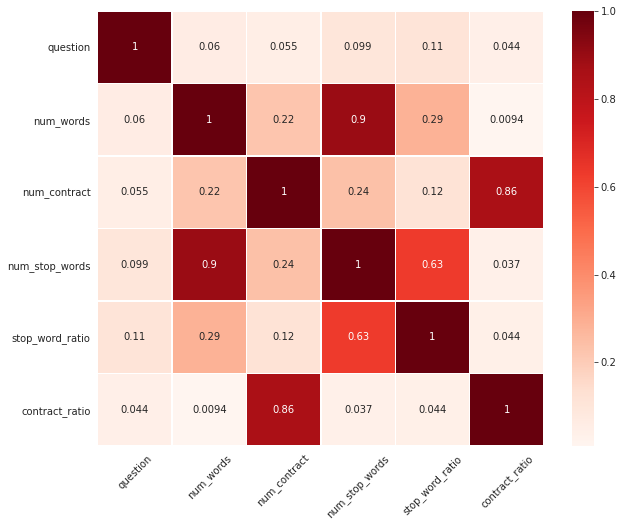

In [0]:
figure, axes = mp.subplots(figsize=(10,8))
sns.heatmap(news_df.corr(), annot=True, vmax=1, linewidths=.5, cmap='Reds')
mp.xticks(rotation=45)

In [0]:
news_df_ = news_df.copy()

In [0]:
news_df_ 

,statement,headline,processed_text,question,num_words,part_speech,num_contract,num_stop_words,stop_word_ratio,contract_ratio
0,says the annies list political group supports ...,Says the Annies List political group supports ...,says the annies list political group supports ...,0,11,VBZ NNS JJ JJ NN VBZ NN NNS NN,0,2,0.181818,0.0
1,when did the decline of coal start it started ...,When did the decline of coal start? It started...,when did the decline of coal start it started ...,1,24,NN NN NN VBD JJ NN VBD VBN NN NN NN VBD JJ NN,0,10,0.416667,0.0
2,hillary clinton agrees with john mccain by vot...,"Hillary Clinton agrees with John McCain ""by vo...","hillary clinton agrees with john mccain ""by vo...",0,19,JJ NN VBZ JJ NN VBG VB NN NN VBP NN NN,0,7,0.368421,0.0
3,health care reform legislation is likely to ma...,Health care reform legislation is likely to ma...,health care reform legislation is likely to ma...,0,12,NN NN NN NN JJ NN JJ NN NN NNS,0,2,0.166667,0.0
4,the economic turnaround started at the end of ...,The economic turnaround started at the end of ...,the economic turnaround started at the end of ...,0,10,JJ NN VBD JJ NN,0,5,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...
10235,there are a larger number of shark attacks in ...,There are a larger number of shark attacks in ...,there are a larger number of shark attacks in ...,0,17,JJR NN NN NNS VBP NNS VBP NN,0,9,0.529412,0.0
10236,democrats have now become the party of the atl...,Democrats have now become the party of the [At...,democrats have now become the party of the [at...,0,14,NNS VBP NN JJ JJ NN NNS,0,7,0.500000,0.0
10237,says an alternative to social security that op...,Says an alternative to Social Security that op...,says an alternative to social security that op...,0,28,VBZ JJ JJ NN VBZ JJ NN NN VBD NNS VB JJ NN NN ...,0,12,0.428571,0.0
10238,on lifting the us cuban embargo and allowing t...,On lifting the U.S. Cuban embargo and allowing...,on lifting the us cuban embargo and allowing t...,0,11,VBG PRP JJ NN VBG NN NN,0,4,0.363636,0.0


## Prepare dataframe for training

In [0]:
news_df.drop(['num_stop_words','num_contract'], axis=1, inplace=True)
news_df.head()

,statement,headline,processed_text,question,num_words,part_speech,stop_word_ratio,contract_ratio
0,says the annies list political group supports ...,Says the Annies List political group supports ...,says the annies list political group supports ...,0,11,VBZ NNS JJ JJ NN VBZ NN NNS NN,0.181818,0.0
1,when did the decline of coal start it started ...,When did the decline of coal start? It started...,when did the decline of coal start it started ...,1,24,NN NN NN VBD JJ NN VBD VBN NN NN NN VBD JJ NN,0.416667,0.0
2,hillary clinton agrees with john mccain by vot...,"Hillary Clinton agrees with John McCain ""by vo...","hillary clinton agrees with john mccain ""by vo...",0,19,JJ NN VBZ JJ NN VBG VB NN NN VBP NN NN,0.368421,0.0
3,health care reform legislation is likely to ma...,Health care reform legislation is likely to ma...,health care reform legislation is likely to ma...,0,12,NN NN NN NN JJ NN JJ NN NN NNS,0.166667,0.0
4,the economic turnaround started at the end of ...,The economic turnaround started at the end of ...,the economic turnaround started at the end of ...,0,10,JJ NN VBD JJ NN,0.500000,0.0


In [0]:
df_train, df_test = train_test_split(news_df, test_size=0.2, random_state=0)


## Tf-IDF modeling

In [0]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

X_train_text = tfidf.fit_transform(df_train['statement'])
X_test_text  = tfidf.transform(df_test['statement'])

## Count Vectorizer

In [0]:
cvec = CountVectorizer()

X_train_pos = cvec.fit_transform(df_train['part_speech'])
X_test_pos  = cvec.transform(df_test['part_speech'])

sc = StandardScaler(with_mean=False)
X_train_pos_sc = sc.fit_transform(X_train_pos)
X_test_pos_sc  = sc.transform(X_test_pos)

['says', 'percent', 'state', 'obama', 'tax', 'health', 'years', 'people', 'president', 'year']


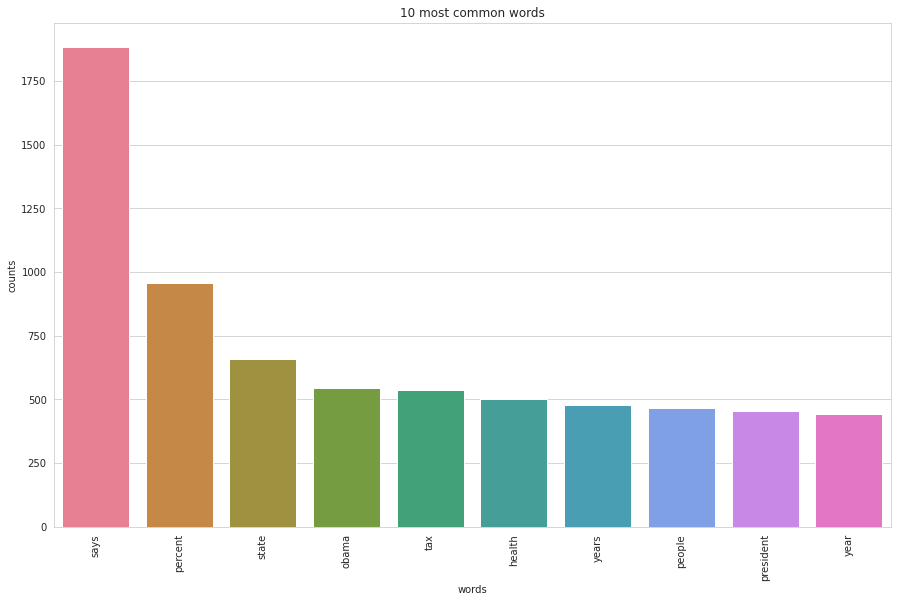

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_train['statement'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
count_data

<8192x10863 sparse matrix of type '<class 'numpy.int64'>'
	with 76308 stored elements in Compressed Sparse Row format>

## LDA modeling

In [0]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
says years state year percent illegal new people crime jobs

Topic #1:
says percent tax obama president state year years people million

Topic #2:
says billion new state budget jobs years taxes tax cut

Topic #3:
says health care obama clinton law president insurance hillary barack

Topic #4:
percent states state tax rate unemployment says federal oil rhode


# LDA with Score

## Preprocessing

### Data

In [0]:
data_text = news_df[['statement']]
data_text['index'] = data_text.index
documents = data_text



In [0]:
print(len(documents))
print(documents[:5])

10240
                                           statement  index
0  says the annies list political group supports ...      0
1  when did the decline of coal start it started ...      1
2  hillary clinton agrees with john mccain by vot...      2
3  health care reform legislation is likely to ma...      3
4  the economic turnaround started at the end of ...      4


### Libraries

In [0]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
stemmer=PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

### After Preprocessing

In [0]:
doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['members', 'of', 'the', 'public', 'are', 'being', 'charged', 'to', 'hear', 'gov', 'scott', 'walker', 'and', 'a', 'dozen', 'members', 'of', 'his', 'administration', 'talk', 'about', 'jobs', 'and', 'the', 'economy', 'at', 'lambeau', 'field']


 tokenized and lemmatized document: 
['member', 'public', 'charg', 'hear', 'scott', 'walker', 'dozen', 'member', 'administr', 'talk', 'job', 'economi', 'lambeau', 'field']


Preprocess the 'content' text, saving the results as ‘processed_docs’

In [0]:
processed_docs = documents['statement'].map(preprocess)
processed_docs[:10]

0    [say, anni, list, polit, group, support, third...
1    [declin, coal, start, start, natur, take, star...
2    [hillari, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legisl, like, mandat, f...
4                    [econom, turnaround, start, term]
5    [chicago, bear, start, quarterback, year, tota...
6               [dunnam, live, district, repres, year]
7    [person, stage, work, activ, year, pass, russ,...
8    [take, million, oregon, lotteri, fund, port, n...
9    [say, primari, oppon, glenn, grothman, leibham...
Name: statement, dtype: object

## Bag of Words on the Data set

creating dictionary from ‘processed_docs’ containing the number of times a word appears in the training set

In [0]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 thirdtrimest
9 administr
10 begin


## Filter out tokens

* less than 15 documents (absolute number) or
* more than 0.5 documents (fraction of total corpus size, not absolute number).
* after the above two steps, keep only the first 100000 most frequent tokens.

In [0]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

## Gensim doc2bow

In [0]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(7, 1),
 (83, 1),
 (123, 1),
 (124, 1),
 (177, 2),
 (248, 1),
 (271, 1),
 (315, 1),
 (532, 1),
 (781, 1),
 (1006, 1)]

In [0]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 7 ("administr") appears 1 time.
Word 83 ("economi") appears 1 time.
Word 123 ("scott") appears 1 time.
Word 124 ("walker") appears 1 time.
Word 177 ("member") appears 2 time.
Word 248 ("job") appears 1 time.
Word 271 ("public") appears 1 time.
Word 315 ("hear") appears 1 time.
Word 532 ("charg") appears 1 time.
Word 781 ("talk") appears 1 time.
Word 1006 ("field") appears 1 time.


## TF-IDF

In [0]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3428417869126144),
 (1, 0.4989917253887079),
 (2, 0.40909647814178873),
 (3, 0.46275444257330145),
 (4, 0.4077630723491094),
 (5, 0.10872219586712885),
 (6, 0.2717975819338144)]


## LDA using TF-IDF

In [0]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.013*"say" + 0.010*"billion" + 0.009*"tax" + 0.009*"year" + 0.009*"plan" + 0.008*"percent" + 0.008*"medicar" + 0.007*"peopl" + 0.007*"citi" + 0.007*"obama"
Topic: 1 Word: 0.018*"percent" + 0.015*"say" + 0.011*"state" + 0.011*"obama" + 0.010*"year" + 0.010*"peopl" + 0.009*"unemploy" + 0.009*"spend" + 0.008*"countri" + 0.008*"million"
Topic: 2 Word: 0.017*"year" + 0.014*"school" + 0.014*"percent" + 0.013*"say" + 0.011*"state" + 0.011*"fund" + 0.009*"take" + 0.009*"tax" + 0.008*"public" + 0.008*"rais"
Topic: 3 Word: 0.011*"say" + 0.011*"candid" + 0.010*"elect" + 0.009*"state" + 0.009*"texa" + 0.009*"governor" + 0.009*"year" + 0.008*"percent" + 0.008*"republican" + 0.008*"lose"
Topic: 4 Word: 0.013*"secur" + 0.012*"social" + 0.011*"say" + 0.009*"percent" + 0.007*"year" + 0.007*"budget" + 0.007*"american" + 0.007*"plan" + 0.007*"texa" + 0.006*"feder"
Topic: 5 Word: 0.016*"state" + 0.013*"say" + 0.011*"health" + 0.010*"million" + 0.009*"care" + 0.008*"percent" + 0.008*"unit" 

# Data Insights

Topic: 0 Word: 0.013*"say" + 0.010*"billion" + 0.009*"tax" + 0.009*"year" + 0.009*"plan" + 0.008*"percent" + 0.008*"medicar" + 0.007*"peopl" + 0.007*"citi" + 0.007*"obama"

Topic: 1 Word: 0.018*"percent" + 0.015*"say" + 0.011*"state" + 0.011*"obama" + 0.010*"year" + 0.010*"peopl" + 0.009*"unemploy" + 0.009*"spend" + 0.008*"countri" + 0.008*"million"

Topic: 2 Word: 0.017*"year" + 0.014*"school" + 0.014*"percent" + 0.013*"say" + 0.011*"state" + 0.011*"fund" + 0.009*"take" + 0.009*"tax" + 0.008*"public" + 0.008*"rais"

Topic: 3 Word: 0.011*"say" + 0.011*"candid" + 0.010*"elect" + 0.009*"state" + 0.009*"texa" + 0.009*"governor" + 0.009*"year" + 0.008*"percent" + 0.008*"republican" + 0.008*"lose"

Topic: 4 Word: 0.013*"secur" + 0.012*"social" + 0.011*"say" + 0.009*"percent" + 0.007*"year" + 0.007*"budget" + 0.007*"american" + 0.007*"plan" + 0.007*"texa" + 0.006*"feder"

Topic: 5 Word: 0.016*"state" + 0.013*"say" + 0.011*"health" + 0.010*"million" + 0.009*"care" + 0.008*"percent" + 0.008*"unit" + 0.007*"dollar" + 0.007*"year" + 0.007*"crime"

Topic: 6 Word: 0.014*"nation" + 0.013*"state" + 0.011*"vote" + 0.011*"debt" + 0.011*"say" + 0.010*"world" + 0.010*"percent" + 0.010*"school" + 0.008*"time" + 0.008*"obama"

Topic: 7 Word: 0.012*"say" + 0.011*"state" + 0.010*"illeg" + 0.009*"florida" + 0.009*"deficit" + 0.008*"immigr" + 0.008*"health" + 0.008*"care" + 0.007*"support" + 0.007*"dont"

Topic: 8 Word: 0.017*"say" + 0.016*"obama" + 0.015*"presid" + 0.012*"barack" + 0.010*"clinton" + 0.010*"john" + 0.009*"mccain" + 0.008*"hillari" + 0.008*"state" + 0.008*"job"

Topic: 9 Word: 0.016*"say" + 0.013*"percent" + 0.010*"year" + 0.010*"obama" + 0.008*"averag" + 0.008*"clinton" + 0.007*"presid" + 0.007*"spend" + 0.007*"barack" + 0.007*"health"

We ran this on 10 topics, to determine what the 10 different topics were. We notice that most of our articles are political articles, and as we dig deeper we see the following.
We can see in the second topic, how the spending of Obama was bad, which led to the unemployment in the country. This shows us that this could be a biased article to discredit the Obama administration.
Most of the topics talked about how the budget changed effecting spending in multiple categories, such as healthcare, schools, public works, and immigration. Showing that these could be biased articles, leading to changing of voting patterns.
 
Items like this showed us how we could use LDA to determine what the context was and what features can potentially be useful to help improve our accuracy of predicting if it’s a fake or real article. For example, we see that all these fake articles had a lot of spelling errors.  
This could mean that if we introduce a spell checker, we could potentially say that bad spelling can show that is a fake article.


## Reference

1. https://www.nltk.org/book/ch05.html
2.  https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
3. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
4. https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28